In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
from PIL import Image
from keras.preprocessing.image  import ImageDataGenerator    # Keras libaray to manage image files

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# /content/drive/MyDrive/insert path

Mounted at /content/drive


In [3]:
base_dir = '/content/drive/Othercomputers/My Surface Laptop/1hundred percent Coding/Personal Programming/ML/Scenes of Nature Dataset/for the autoencoder'
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir,'testing')
# test_dir = os.path.join(base_dir, 'predicting')

train_mountain_dir = os.path.join(train_dir, 'mountain')
val_mountain_dir = os.path.join(validation_dir, 'mountain')
# test_mountain_dir = os.path.join(test_dir, 'mountain')

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
mountain_train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='input',
    shuffle=True
)

mountain_validation_generator = test_datagen.flow_from_directory(
  validation_dir,
  target_size=(150, 150),
	batch_size=20,
  class_mode='input'
)

Found 1000 images belonging to 1 classes.
Found 525 images belonging to 1 classes.


In [6]:
input_img = Input(shape=(150, 150, 3))  # CIFAR10 dimensions

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Cropping2D(cropping=((1, 1), (1, 1)))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 16)        2320  

In [7]:
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

In [8]:
noise_factor = 0.3

noisy_train_gen = mountain_train_generator
noisy_val_gen = mountain_validation_generator

for i in range(len(noisy_train_gen)):
  for j in range(len(noisy_train_gen[i])):
    for k in range(len(noisy_train_gen[i][j])):
      noisy_train_gen[i][j][k] = noisy_train_gen[i][j][k] + noise_factor * np.random.normal(loc=0.0,
                                                                                scale=1.0,
                                                               size=noisy_train_gen[i][j][k].shape)

for i in range(len(noisy_val_gen)):
  for j in range(len(noisy_val_gen[i])):
    for k in range(len(noisy_val_gen[i][j])):
      noisy_val_gen[i][j][k] = noisy_val_gen[i][j][k] + noise_factor * np.random.normal(loc=0.0,
                                                                                scale=1.0,
                                                               size=noisy_val_gen[i][j][k].shape)

In [9]:
from keras.callbacks import TensorBoard

In [10]:
spe = noisy_train_gen.samples // noisy_train_gen.batch_size

history = autoencoder.fit(noisy_train_gen,
                          steps_per_epoch=spe,
                epochs=50,
                shuffle=True,
                validation_data=noisy_val_gen,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder_denoise',
                                       histogram_freq=0, write_graph=False)])

Epoch 1/50
31/31 [==============================] - 18s 397ms/step - loss: 0.6141 - val_loss: 0.5624
Epoch 2/50
31/31 [==============================] - 11s 361ms/step - loss: 0.5357 - val_loss: 0.5373
Epoch 3/50
31/31 [==============================] - 11s 363ms/step - loss: 0.5266 - val_loss: 0.5331
Epoch 4/50
31/31 [==============================] - 11s 365ms/step - loss: 0.5266 - val_loss: 0.5319
Epoch 5/50
31/31 [==============================] - 11s 354ms/step - loss: 0.5254 - val_loss: 0.5308
Epoch 6/50
31/31 [==============================] - 10s 335ms/step - loss: 0.5247 - val_loss: 0.5304
Epoch 7/50
31/31 [==============================] - 11s 356ms/step - loss: 0.5242 - val_loss: 0.5292
Epoch 8/50
31/31 [==============================] - 11s 363ms/step - loss: 0.5237 - val_loss: 0.5288
Epoch 9/50
31/31 [==============================] - 11s 357ms/step - loss: 0.5228 - val_loss: 0.5281
Epoch 10/50
31/31 [==============================] - 11s 354ms/step - loss: 0.5233 - val_lo

In [11]:
'''
spe = mountain_train_generator.samples // mountain_train_generator.batch_size

history = autoencoder.fit(
      mountain_train_generator,
      steps_per_epoch=spe,
      epochs=50,
      validation_data=mountain_validation_generator,
      validation_steps=spe,
    )
'''

'\nspe = mountain_train_generator.samples // mountain_train_generator.batch_size\n\nhistory = autoencoder.fit(\n      mountain_train_generator,\n      steps_per_epoch=spe,\n      epochs=50,\n      validation_data=mountain_validation_generator,\n      validation_steps=spe,\n    )\n'

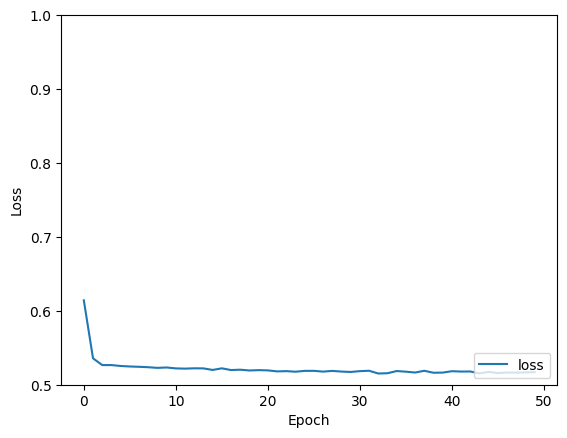

In [12]:
plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [13]:
decoded_imgs = autoencoder.predict(noisy_val_gen)

27/27 [==============================] - 2s 67ms/step


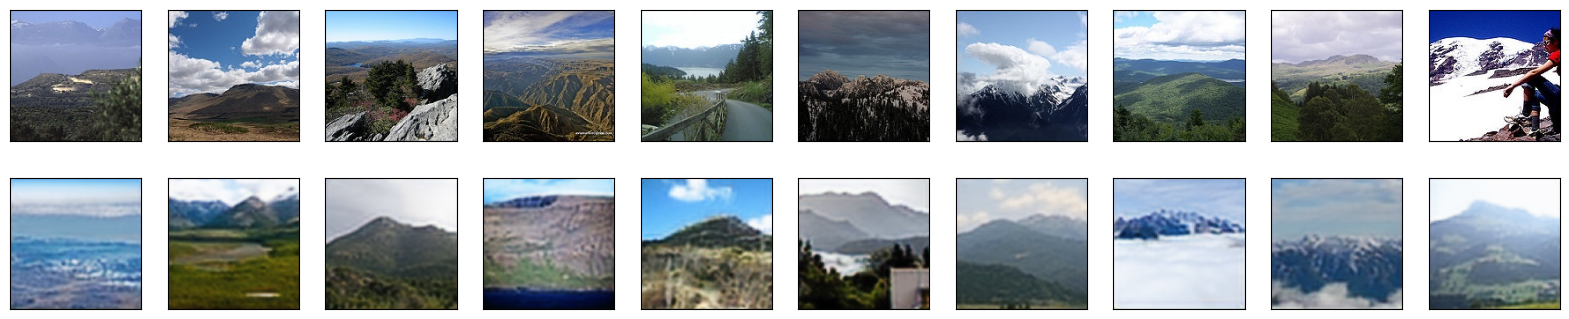

In [14]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(len(noisy_val_gen)):
  for j in range(len(noisy_val_gen[i])):
    pass

for k in range(1, n+1):
  # Display original
  ax = plt.subplot(2, n, k)
  plt.imshow(noisy_val_gen[0][0][k])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Display reconstruction
  ax = plt.subplot(2, n, k + n)
  # print(decoded_imgs[k].shape)
  plt.imshow(decoded_imgs[k])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()